### smoothing

In [1]:
from os.path import join as opj
import os
import json
from nipype.interfaces.fsl import (BET, ExtractROI, FAST, FLIRT, ImageMaths,
                                   MCFLIRT, SliceTimer, Threshold)
from nipype.interfaces.spm import Smooth
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.rapidart import ArtifactDetect
from nipype import Workflow, Node

200929-13:31:33,357 nipype.utils WARNING:
	 A newer version (1.5.1) of nipy/nipype is available. You are using 1.5.0-rc1.post-dev


### check TR

In [2]:
import numpy as np
import nibabel as nib

In [3]:
func_img = nib.load('/data/sub-06/func/sub-06_task-tsl_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')

In [4]:
header = func_img.header
header.get_zooms()

(2.4, 2.4, 3.12, 2.0)

image spatial voxel sizes (2.4 x 2.4 x 3.12)mm, TR=2s

### nipype smoothing workflow

In [46]:
experiment_dir = '/output'
output_dir = 'datasink'
working_dir = 'workingdir'
data_dir = '/data'

# list of subject identifiers
subject_list = ['06']

# Smoothing widths to apply
fwhm = [4,8]

# TR of functional images
TR = 2.

# Isometric resample of functional images to voxel size (in mm)
iso_size = 4

In [47]:
# ExtractROI - skip dummy scans
extract = Node(ExtractROI(t_min=4, t_size=-1, output_type='NIFTI_GZ'),
               name="extract")

# Smooth - image smoothing
smooth = Node(Smooth(), name="smooth")
smooth.iterables = ("fwhm", fwhm)

### specify input/output

In [10]:
for f in os.listdir('/data/sub-06/anat'):
    if f.endswith('T1w.nii.gz'):
        print(f)

sub-06_desc-preproc_T1w.nii.gz
sub-06_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz


In [11]:
for f in os.listdir('/data/sub-06/func'):
    if f.endswith('bold.nii.gz'):
        print(f)

sub-06_task-tsl_run-5_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
sub-06_task-tsl_run-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
sub-06_task-tsl_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
sub-06_task-tsl_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
sub-06_task-tsl_run-4_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


In [48]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
anat_file = opj('sub-{subject_id}', 'anat', 
                'sub-{subject_id}_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz')
func_file = opj('sub-{subject_id}', 'func',
                'sub-{subject_id}_*_bold.nii.gz')

templates = {'anat': anat_file,
             'func': func_file}
selectfiles = Node(SelectFiles(templates,
                    base_directory=data_dir),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

## Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-'),
                 ('_fwhm_', 'fwhm-'),
                 ('_roi', '')
                 ]
subjFolders = [('fwhm-%s/' % f, 'fwhm-%s_' % f) for f in fwhm]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

In [49]:
# Create a preprocessing workflow
preproc = Workflow(name='preproc')
preproc.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the preprocessing workflow
preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id')])                ])

In [50]:
preproc.run()

200929-14:14:57,231 nipype.workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging', 'monitoring']
200929-14:14:57,241 nipype.workflow INFO:
	 Running serially.
200929-14:14:57,242 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/output/workingdir/preproc/_subject_id_06/selectfiles".
200929-14:14:57,248 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
200929-14:14:57,253 nipype.workflow INFO:
	 [Node] Finished "preproc.selectfiles".


In [51]:
preproc.outputs


infosource = 
subject_id = None

selectfiles = 
anat = None
func = None


In [19]:
# Create a preprocessing workflow
preproc = Workflow(name='preproc')
preproc.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the preprocessing workflow
preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id')]),
                 (selectfiles, extract, [('func', 'in_file')]),
                 (extract, smooth, [('roi_file', 'in_files')])
                ])

200929-14:07:48,608 nipype.workflow INFO:
	 Generated workflow graph: /output/workingdir/preproc/graph.png (graph2use=colored, simple_form=True).


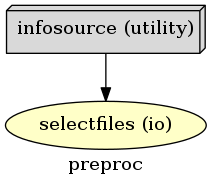

In [23]:
preproc.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(preproc.base_dir, 'preproc', 'graph.png'))

In [21]:
preproc.run('MultiProc', plugin_args={'n_procs': 4})

200929-14:05:05,921 nipype.workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging', 'monitoring']
200929-14:05:05,976 nipype.workflow INFO:
	 Running in parallel.
200929-14:05:06,39 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 14.07/14.07, Free processors: 4/4.
200929-14:05:06,271 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/output/workingdir/preproc/_subject_id_06/selectfiles".200929-14:05:06,271 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/output/workingdir/preproc/_subject_id_07/selectfiles".

200929-14:05:06,285 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")200929-14:05:06,284 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")

200929-14:05:06,299 nipype.workflow INFO:
	 [Node] Finished "preproc.selectfiles".
200929-14:05:06,323 nipype.workflow INFO:
	 [Node] Finished "preproc.selectfiles".

exception calling callback for <Future at 0x7f730f1978d0 state=finished raised FileNotFoundError>
concurrent.futures.process._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/plugins/multiproc.py", line 148, in __init__
    mp_context=mp_context,
TypeError: __init__() got an unexpected keyword argument 'initializer'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/interfaces/base/traits_extension.py", line 129, in validate
    value = Path(value)  # Use pathlib's validation
  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/pathlib.py", line 1001, in __new__
    self = cls._from_parts(args, init=False)
  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/pathlib.py", line 656, in _from_parts
    drv, root, parts = self._parse_args(args)
  File "/opt/miniconda

200929-14:05:10,33 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 0 jobs ready. Free memory (GB): 13.67/14.07, Free processors: 2/4.
                     Currently running:
                       * preproc.extract
                       * preproc.extract


Process Process-4:
Process Process-3:
Process Process-2:
Process Process-1:
Traceback (most recent call last):
  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/plugins/multiproc.py", line 148, in __init__
    mp_context=mp_context,
TypeError: __init__() got an unexpected keyword argument 'initializer'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/plugins/multiproc.py", line 148, in __init__
    mp_context=mp_context,
  File "/opt/miniconda-la

KeyboardInterrupt: 